# Training Deep Neural Networks on a GPU with PyTorch

### Part 4 of "PyTorch: Zero to GANs"

*This notebook is the fourth in a series of tutorials on building deep learning models with PyTorch, an open source neural networks library. Check out the full series:*

1. [PyTorch Basics: Tensors & Gradients](https://jovian.ml/aakashns/01-pytorch-basics)
2. [Linear Regression & Gradient Descent](https://jovian.ml/aakashns/02-linear-regression)
3. [Image Classfication using Logistic Regression](https://jovian.ml/aakashns/03-logistic-regression) 
4. [Training Deep Neural Networks on a GPU](https://jovian.ml/aakashns/04-feedforward-nn)
5. [Image Classification using Convolutional Neural Networks](https://jovian.ml/aakashns/05-cifar10-cnn)
6. [Data Augmentation, Regularization and ResNets](https://jovian.ml/aakashns/05b-cifar10-resnet)
7. [Generating Images using Generative Adverserial Networks](https://jovian.ml/aakashns/06-mnist-gan)

In [the previous tutorial](https://jovian.ml/aakashns/03-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%. 

![](https://cdn-images-1.medium.com/max/1600/1*q2nyeRU8uvjPeKpo_lMXgQ.jpeg)

However, we also noticed that it's quite difficult to improve the accuracy beyond 87%, due to the limited power of the model. In this post, we'll try to improve upon it using a *feedforward neural network*. 

## System Setup

This tutorial takes a code-first approach, and you should try to follow along by running and experimenting with the code yourself. The easiest way to start executing this notebook is to click the **"Run"** button at the top of this page, and select **"Run on Kaggle"**. This will run the notebook on Kaggle, a free online service for running Jupyter notebooks (you might need to create an account).

### Running on your computer locally
*(Skip this if you are running on Kaggle)* You can clone this notebook, install the required dependencies using conda, and start Jupyter by running the following commands on the terminal:

```
pip install jovian --upgrade                # Install the jovian library 
jovian clone aakashns/04-feedforward-nn     # Download notebook
cd 04-feedforward-nn                        # Enter the created directory 
conda create -n 04-feedfoward-nn python=3.8 # Create a conda environment
conda activate 04-feedforward-nn            # Activate virtual environment
conda install jupyter                       # Install Jupyter
jupyter notebook                            # Start Jupyter
```

On older versions of conda, you might need to run `source activate 04-feedfoward-nn` to activate the virtual environment. For a more detailed explanation of the above steps, check out the System setup section in [the first notebook](https://jovian.ml/aakashns/01-pytorch-basics).

## Preparing the Data

The data preparation is identical to the [previous tutorial](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0). We begin by importing the required modules & classes.

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pandas pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet

In [2]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

We download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [4]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [5]:
batch_size=128

In [6]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Can you figure out what the `num_workers` and `pin_memory` are used for? Try looking into the documentation: https://pytorch.org/docs/stable/data.html

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


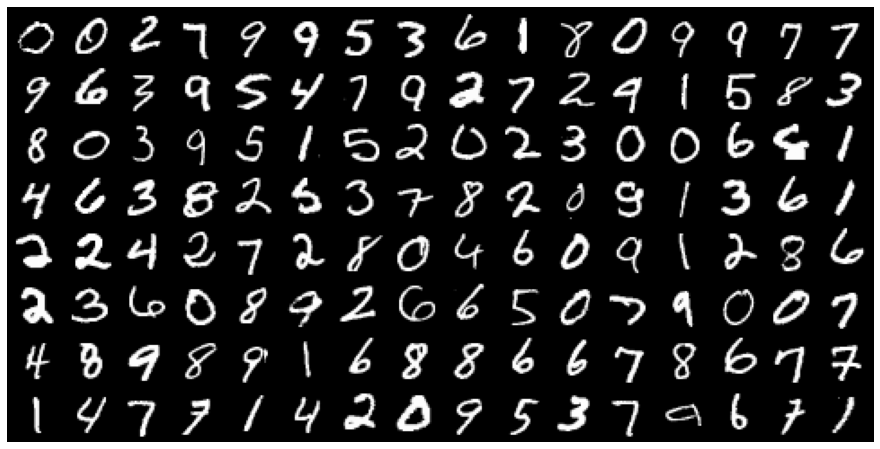

In [7]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## 线性回归模型

To improve upon [logistic regression](https://jvn.io/aakashns/a1b40b04f5174a18bd05b17e3dffb0f0), we'll create a neural network with **hidden layer**. Here's what this means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a layer in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784`(picture: 28 * 28) into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

* The intermediate outputs are then passed into a non-linear *activation function*, which operates on individual elements of the output matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a **Rectified Linear Unit** or **ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
class MnistModel(nn.Module):
    """Feedfoward neural network with hidden layer"""
    def __init__(self, in_size, hidden_size1, hidden_size2, hidden_size3, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.linear3 = nn.Linear(hidden_size2, hidden_size3)
        # output layer
        self.linear4 = nn.Linear(hidden_size3, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors ———— 128*28*28 转 128*784
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        h1out = F.relu(self.linear1(xb))
        h2out = F.relu(self.linear2(h1out))
        h3out = F.relu(self.linear3(h2out))

        # Get predictions using output layer
        out = self.linear4(h3out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We'll create a model that contains hidden layer

In [10]:
input_size = 784
hidden_size1 = 256 # you can change this
hidden_size2 = 128
hidden_size3 = 32
num_classes = 10

In [11]:
model = MnistModel(input_size, hidden_size1=256, hidden_size2=128, hidden_size3=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [12]:
for t in model.parameters():
    print(t.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset, and pass them into our model.

In [13]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3020823001861572
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0882,  0.1184,  0.1462, -0.0171, -0.0332, -0.1090, -0.0931,  0.1277,
         -0.0770,  0.0425],
        [ 0.0948,  0.1555,  0.1483,  0.0032, -0.0168, -0.1098, -0.0768,  0.1353,
         -0.0627,  0.0491]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on [Kaggle kernels](https://www.kaggle.com/kernels) or [Google Colab](https://colab.research.google.com/), or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html) or [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [14]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        #torch.cuda.set_device(3)    ###############指定GPU
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [16]:
device = get_default_device()
print(device)
print(torch.cuda.current_device())

cuda
0


Next, let's define a function that can move data and model to a chosen device.

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [18]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [19]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [20]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [21]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([7, 6, 1, 6, 8, 7, 9, 3, 7, 6, 1, 6, 1, 6, 2, 2, 8, 6, 2, 3, 4, 4, 9, 3,
        7, 1, 6, 7, 0, 1, 1, 9, 5, 8, 9, 3, 7, 0, 9, 6, 8, 8, 3, 1, 4, 7, 8, 8,
        0, 5, 2, 5, 7, 0, 4, 9, 1, 7, 9, 0, 3, 9, 3, 6, 3, 1, 2, 7, 6, 6, 3, 9,
        2, 4, 1, 9, 3, 7, 3, 7, 7, 4, 7, 3, 0, 4, 5, 1, 8, 6, 1, 2, 2, 1, 9, 1,
        4, 0, 2, 7, 4, 7, 5, 3, 4, 6, 9, 4, 4, 6, 4, 2, 6, 1, 6, 1, 1, 7, 8, 1,
        9, 8, 9, 6, 7, 5, 0, 6, 3, 7, 1, 6, 1, 8, 5, 4, 4, 1, 6, 8, 3, 0, 0, 7,
        4, 1, 6, 7, 2, 1, 5, 1, 3, 0, 1, 1, 5, 2, 1, 0, 0, 3, 0, 5, 0, 3, 7, 8,
        8, 1, 3, 4, 2, 3, 4, 7, 8, 6, 8, 2, 7, 9, 5, 7, 9, 1, 5, 3, 6, 1, 2, 9,
        0, 1, 9, 0, 3, 7, 3, 6, 5, 7, 1, 9, 9, 3, 7, 7, 6, 6, 5, 7, 3, 7, 9, 5,
        4, 7, 6, 8, 0, 7, 0, 8, 1, 2, 4, 0, 0, 7, 8, 2, 6, 4, 8, 2, 7, 1, 9, 6,
        6, 4, 1, 1, 7, 8, 2, 3, 0, 9, 3, 0, 9, 0, 4, 2], device='cuda:0')


## Training the Model

We can use the exact same training loops from the logistic regression notebook.

In [22]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [23]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size1=256, hidden_size2=128, hidden_size3=32, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [24]:
history = [evaluate(model, val_loader)]
#1个epoch的结果
history

[{'val_loss': 2.3057587146759033, 'val_acc': 0.10117187350988388}]

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.5.

In [25]:
history += fit(10, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2179, val_acc: 0.9311
Epoch [1], val_loss: 0.1331, val_acc: 0.9611
Epoch [2], val_loss: 0.1169, val_acc: 0.9629
Epoch [3], val_loss: 0.1088, val_acc: 0.9659
Epoch [4], val_loss: 0.0920, val_acc: 0.9716
Epoch [5], val_loss: 0.0936, val_acc: 0.9717
Epoch [6], val_loss: 0.1113, val_acc: 0.9703
Epoch [7], val_loss: 0.1086, val_acc: 0.9704
Epoch [8], val_loss: 0.1002, val_acc: 0.9748
Epoch [9], val_loss: 0.1067, val_acc: 0.9771


96% is pretty good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [26]:
history += fit(30, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0918, val_acc: 0.9791
Epoch [1], val_loss: 0.0913, val_acc: 0.9787
Epoch [2], val_loss: 0.0912, val_acc: 0.9792
Epoch [3], val_loss: 0.0937, val_acc: 0.9796
Epoch [4], val_loss: 0.0940, val_acc: 0.9794
Epoch [5], val_loss: 0.0933, val_acc: 0.9794
Epoch [6], val_loss: 0.0947, val_acc: 0.9792
Epoch [7], val_loss: 0.0960, val_acc: 0.9795
Epoch [8], val_loss: 0.0961, val_acc: 0.9794
Epoch [9], val_loss: 0.0973, val_acc: 0.9796
Epoch [10], val_loss: 0.0981, val_acc: 0.9797
Epoch [11], val_loss: 0.0991, val_acc: 0.9795
Epoch [12], val_loss: 0.0992, val_acc: 0.9794
Epoch [13], val_loss: 0.0994, val_acc: 0.9798
Epoch [14], val_loss: 0.1009, val_acc: 0.9794
Epoch [15], val_loss: 0.1015, val_acc: 0.9794
Epoch [16], val_loss: 0.1018, val_acc: 0.9796
Epoch [17], val_loss: 0.1027, val_acc: 0.9792
Epoch [18], val_loss: 0.1033, val_acc: 0.9793
Epoch [19], val_loss: 0.1035, val_acc: 0.9793
Epoch [20], val_loss: 0.1042, val_acc: 0.9790
Epoch [21], val_loss: 0.1047, val_acc: 0.978

We can now plot the losses & accuracies to study how the model improves over time.

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

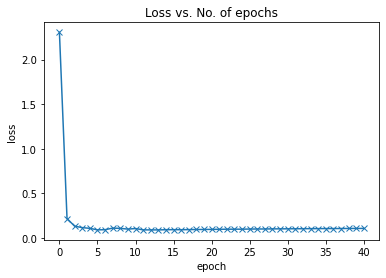

In [28]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

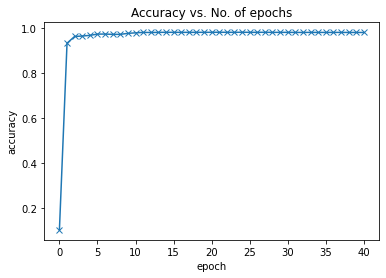

In [29]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model outperforms the logistic regression model (which could only reach around 86% accuracy) by a huge margin! It quickly reaches an accuracy of 97%, but doesn't improve much beyond this. To improve the accuracy further, we need to make the model more powerful. As you can probably guess, this can be achieved by increasing the size of the hidden layer, or adding more hidden layers. I encourage you to try out both these approaches and see which one works better.

## Summary and Further Reading

Here is a summary of the topics covered in this tutorial:

* We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

* We defined some utilities like `get_default_device`, `to_device` and `DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

* We were able to use the exact same training loop: the `fit` function we had define earlier to train out model and evaluate it using the validation dataset.

There's a lot of scope to experiment here, and I encourage you to use the interactive nature of Jupyter to play around with the various parameters. Here are a few ideas:

* Try changing the size of the hidden layer, or add more hidden layers and see if you can achieve a higher accuracy.

* Try changing the batch size and learning rate to see if you can achieve the same accuracy in fewer epochs.

* Compare the training times on a CPU vs. GPU. Do you see a significant difference. How does it vary with the size of the dataset and the size of the model (no. of weights and parameters)?

* Try building a model for a different dataset, such as the [CIFAR10 or CIFAR100 datasets](https://www.cs.toronto.edu/~kriz/cifar.html).

Here are some references for further reading:

* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), also known as the Universal Approximation Theorem.

* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - A visual and intuitive introduction to what neural networks are and what the intermediate layers represent

* [Stanford CS229 Lecture notes on Backpropagation](http://cs229.stanford.edu/notes/cs229-notes-backprop.pdf) - for a more mathematical treatment of how gradients are calculated and weights are updated for neural networks with multiple layers.

In [30]:
class ResidualBlock(nn.Module):
    """
    每一个ResidualBlock,需要保证输入和输出的维度不变
    所以卷积核的通道数都设置成一样
    """
    def __init__(self, channel):
        super().__init__()
        self.resconv1 = nn.Conv2d(channel, channel, kernel_size=3, padding=1) #有padding卷积后大小不变
        self.resconv2 = nn.Conv2d(channel, channel, kernel_size=3, padding=1)

    def forward(self, x):
        """
        ResidualBlock中有跳跃连接;
        在得到第二次卷积结果时,需要加上该残差块的输入,
        再将结果进行激活,实现跳跃连接 ==> 可以避免梯度消失
        在求导时,因为有加上原始的输入x,所以梯度为: dy + 1,在1附近
        """
        y = F.relu(self.resconv1(x))
        y = self.resconv2(y)

        return F.relu(x + y)


class ResNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)
        #(128, 1, 28, 28) ==> (128, 16, 24, 24)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        #(128, 16, 24, 24) ==> (128, 32, 20, 20)
        self.res_block_1 = ResidualBlock(16)
        self.res_block_2 = ResidualBlock(32)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        #print(f'Input.shape: {x.shape}')
        in_size = x.size(0)
        #print(f'in_size: {in_size}')
        x = F.relu(self.conv1(x))
        #print(f'Conv1_O.shape: {x.shape}')
        x = F.max_pool2d(x, 2) #2*2中找最大的
        #print(f'Max_pool2d_O.shape: {x.shape}')
        x = self.res_block_1(x)
        #print(f'Res_block_1_O.shape: {x.shape}')
        
        x = F.relu(self.conv2(x))
        #print(f'Conv2_O.shape: {x.shape}')
        x = F.max_pool2d(x, 2)
        #print(f'Max_pool2d_O.shape: {x.shape}')
        x = self.res_block_2(x)
        #print(f'Res_block_2_O.shape: {x.shape}')
        
        x = x.view(in_size, -1)
        #print(f'x.view(in_size, -1).shape: {x.shape}')
        x = self.fc1(x)
        #print(f'Fc1(liner)_O.shape: {x.shape}')
        y = F.log_softmax(x, dim=1)
        #print(f'y.shape: {y.shape}')
        return y

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [31]:
model = ResNetModel()
to_device(model, device)

ResNetModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (res_block_1): ResidualBlock(
    (resconv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resconv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (res_block_2): ResidualBlock(
    (resconv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (resconv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

In [32]:
#验证模型
X = torch.rand((128, 1, 28, 28)).to('cuda')
y = model(X)
print(y)
'''验证模型另一方法
for name, layer in model.named_children():
    #X = layer(X)
    print(name)#, ' output shape:\t', X.shape)
'''

tensor([[-2.2874, -2.4552, -2.4216,  ..., -2.3169, -2.3072, -2.1994],
        [-2.2845, -2.4462, -2.4283,  ..., -2.3209, -2.3218, -2.2091],
        [-2.2642, -2.4567, -2.4038,  ..., -2.3301, -2.3105, -2.1924],
        ...,
        [-2.2560, -2.4678, -2.4050,  ..., -2.3319, -2.3153, -2.2085],
        [-2.3096, -2.4380, -2.3952,  ..., -2.3113, -2.3039, -2.1826],
        [-2.2644, -2.4710, -2.4270,  ..., -2.3128, -2.3076, -2.2046]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


"验证模型另一方法\nfor name, layer in model.named_children():\n    #X = layer(X)\n    print(name)#, ' output shape:\t', X.shape)\n"

In [33]:
#模型有dropout，BN等时要指定train/eval模式
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            
        # Validation phase
        model.eval()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [34]:
history = [evaluate(model, val_loader)]
#1个epoch的结果
history

[{'val_loss': 2.309264898300171, 'val_acc': 0.08544921875}]

In [35]:
history += fit(30, 0.005, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8632, val_acc: 0.7320
Epoch [1], val_loss: 0.3990, val_acc: 0.8777
Epoch [2], val_loss: 0.3389, val_acc: 0.8908
Epoch [3], val_loss: 0.2611, val_acc: 0.9195
Epoch [4], val_loss: 0.2223, val_acc: 0.9322
Epoch [5], val_loss: 0.2021, val_acc: 0.9370
Epoch [6], val_loss: 0.1747, val_acc: 0.9468
Epoch [7], val_loss: 0.1618, val_acc: 0.9517
Epoch [8], val_loss: 0.1539, val_acc: 0.9548
Epoch [9], val_loss: 0.1312, val_acc: 0.9604
Epoch [10], val_loss: 0.1433, val_acc: 0.9576
Epoch [11], val_loss: 0.1186, val_acc: 0.9650
Epoch [12], val_loss: 0.1132, val_acc: 0.9649
Epoch [13], val_loss: 0.1097, val_acc: 0.9682
Epoch [14], val_loss: 0.1069, val_acc: 0.9672
Epoch [15], val_loss: 0.1030, val_acc: 0.9690
Epoch [16], val_loss: 0.0998, val_acc: 0.9705
Epoch [17], val_loss: 0.0993, val_acc: 0.9688
Epoch [18], val_loss: 0.0862, val_acc: 0.9727
Epoch [19], val_loss: 0.0847, val_acc: 0.9750
Epoch [20], val_loss: 0.1031, val_acc: 0.9664
Epoch [21], val_loss: 0.0833, val_acc: 0.974

In [36]:
history += fit(30, 1e-3, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0645, val_acc: 0.9794
Epoch [1], val_loss: 0.0644, val_acc: 0.9794
Epoch [2], val_loss: 0.0655, val_acc: 0.9788
Epoch [3], val_loss: 0.0651, val_acc: 0.9791
Epoch [4], val_loss: 0.0647, val_acc: 0.9793
Epoch [5], val_loss: 0.0639, val_acc: 0.9798
Epoch [6], val_loss: 0.0646, val_acc: 0.9792
Epoch [7], val_loss: 0.0648, val_acc: 0.9788
Epoch [8], val_loss: 0.0647, val_acc: 0.9790
Epoch [9], val_loss: 0.0666, val_acc: 0.9790
Epoch [10], val_loss: 0.0631, val_acc: 0.9794
Epoch [11], val_loss: 0.0658, val_acc: 0.9789
Epoch [12], val_loss: 0.0642, val_acc: 0.9794
Epoch [13], val_loss: 0.0632, val_acc: 0.9799
Epoch [14], val_loss: 0.0635, val_acc: 0.9801
Epoch [15], val_loss: 0.0624, val_acc: 0.9810
Epoch [16], val_loss: 0.0628, val_acc: 0.9796
Epoch [17], val_loss: 0.0631, val_acc: 0.9798
Epoch [18], val_loss: 0.0625, val_acc: 0.9804
Epoch [19], val_loss: 0.0632, val_acc: 0.9805
Epoch [20], val_loss: 0.0638, val_acc: 0.9805
Epoch [21], val_loss: 0.0618, val_acc: 0.980

In [37]:
history += fit(50, 1e-4, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0611, val_acc: 0.9806
Epoch [1], val_loss: 0.0609, val_acc: 0.9807
Epoch [2], val_loss: 0.0610, val_acc: 0.9804
Epoch [3], val_loss: 0.0607, val_acc: 0.9806
Epoch [4], val_loss: 0.0609, val_acc: 0.9804
Epoch [5], val_loss: 0.0609, val_acc: 0.9803
Epoch [6], val_loss: 0.0609, val_acc: 0.9804
Epoch [7], val_loss: 0.0608, val_acc: 0.9805
Epoch [8], val_loss: 0.0610, val_acc: 0.9804
Epoch [9], val_loss: 0.0607, val_acc: 0.9803
Epoch [10], val_loss: 0.0608, val_acc: 0.9804
Epoch [11], val_loss: 0.0608, val_acc: 0.9805
Epoch [12], val_loss: 0.0605, val_acc: 0.9805
Epoch [13], val_loss: 0.0608, val_acc: 0.9807
Epoch [14], val_loss: 0.0608, val_acc: 0.9804
Epoch [15], val_loss: 0.0608, val_acc: 0.9804
Epoch [16], val_loss: 0.0609, val_acc: 0.9802
Epoch [17], val_loss: 0.0608, val_acc: 0.9806
Epoch [18], val_loss: 0.0608, val_acc: 0.9805
Epoch [19], val_loss: 0.0608, val_acc: 0.9803
Epoch [20], val_loss: 0.0607, val_acc: 0.9805
Epoch [21], val_loss: 0.0606, val_acc: 0.980

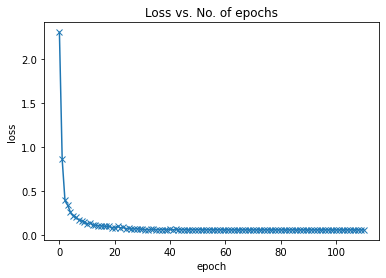

In [38]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

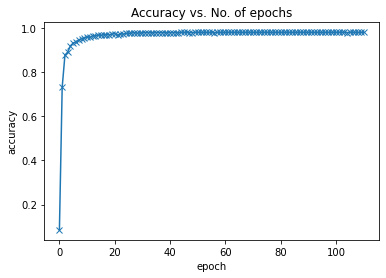

In [39]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');